In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import namedtuple, deque

In [57]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import causallearn

from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import io
import os
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import Normalize
import matplotlib as mp

In [58]:
# Define the DDQN network
class Net(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = self.relu(self.fc1(state))
        return self.fc2(x)

# Prepareoffline samples

In [59]:
#experiment: bridge, different pktsize-corresponding the different ddioway?

In [60]:
import pandas as pd

# Path to your CSV file
csv_file = f'..\\DRL_framework\\ndpi-stats-random\\ndpi-stats-random_2000s.csv'

# Read the CSV file
#df = pd.read_csv(csv_file, header=[0, 1])

In [61]:
import pandas as pd
state_columns_1 = ["input_rate", "output_rate", "latency_new_latency","packetsize"]
#state_columns = ["input_rate", "output_rate", "latency_new_latency","ndpi_stats-pcm_new_Socket 0-PhysIPC", "ndpi_stats-pcm_new_Socket 0-L3MISS", "ndpi_stats-pcm_new_Socket 0-L3HIT",
              #     "pcm-pcie_new_skt-0_PCIRdCur-total", "pcm-pcie_new_skt-0_ItoM-total","packetsize"]
#state_columns = ["ndpi_stats-pcm_new_Socket 0-PhysIPC", "ndpi_stats-pcm_new_Socket 0-L3MISS", "ndpi_stats-pcm_new_Socket 0-L3HIT",
           #        "pcm-pcie_new_skt-0_PCIRdCur", "pcm-pcie_new_skt-0_ItoM"]
action_column = ["ddio_ways_new_ddio_ways"]
#stateskt-0_PCIRdCur-total
df = pd.read_csv(csv_file, usecols=state_columns_1 +action_column)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   input_rate               1986 non-null   float64
 1   output_rate              1986 non-null   float64
 2   ddio_ways_new_ddio_ways  1986 non-null   float64
 3   latency_new_latency      1986 non-null   float64
 4   packetsize               1986 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 77.7 KB


In [9]:
print(df[  "pcm-pcie_new_skt-0_PCIRdCur-total"])

0       24633966.0
1       15212512.0
2       24484684.0
3       24624460.0
4       24474562.0
           ...    
1981    21373422.0
1982    21380730.0
1983    21367038.0
1984    21039774.0
1985    21038388.0
Name: pcm-pcie_new_skt-0_PCIRdCur-total, Length: 1986, dtype: float64


In [44]:
a_sample = df.iloc[700]
print(a_sample)

input_rate                 9.995161e+03
output_rate                9.900075e+03
ddio_ways_new_ddio_ways    1.700000e+01
latency_new_latency        1.354739e+06
packetsize                 1.514000e+03
Name: 700, dtype: float64


In [46]:
#scaler = StandardScaler()
scaler = MinMaxScaler()
state_space = df[state_columns_1].values 
scaler.fit(state_space)
state_space_scaled = scaler.transform(state_space)

In [47]:
#reward
r_2 = a_sample['output_rate']/1000-a_sample['latency_new_latency']/100000-a_sample['ddio_ways_new_ddio_ways']/20
r_1 =-a_sample['latency_new_latency']/100000#-#a_sample['ddio_ways_new_ddio_ways']/20

print(r_2)

-4.497314927188


In [48]:
#generate samples
samples=[]
scaler = StandardScaler()
for i in range(len(df) - 1):  
   # state = df.loc[i, state_columns].values.tolist()
    state = state_space_scaled[i]
    action = df.loc[i, action_column].values.tolist()
   # next_state = df.loc[i + 1, state_columns].values.tolist()
    next_state = state_space_scaled[i + 1]
    next_action = df.loc[i + 1, action_column].values.tolist()
  #  reward = df.loc[i, 'throughput'] * df.loc[i, 'throughput']* df.loc[i, 'throughput']-df.loc[i, 'latency']/1000000
    reward = df.loc[i, 'output_rate']/1000  -df.loc[i, 'latency_new_latency']/100000-df.loc[i, 'ddio_ways_new_ddio_ways']/20

    samples.append((state, action, next_state, next_action, reward))
samples_df = pd.DataFrame(samples, columns=['State', 'Action', 'Next State', 'Next Action', 'Reward'])

In [63]:
#generate samples
samples=[]
scaler = StandardScaler()
for i in range(len(df) - 1):  
    state = df.loc[i, state_columns_1].values.tolist()
   # state = state_space_scaled[i]
    action = df.loc[i, action_column].values.tolist()
    next_state = df.loc[i + 1, state_columns_1].values.tolist()
   # next_state = state_space_scaled[i + 1]
   # next_action = df.loc[i + 1, action_column].values.tolist()
    reward = df.loc[i, 'output_rate']/1000  -df.loc[i, 'latency_new_latency']/100000-df.loc[i, 'ddio_ways_new_ddio_ways']/20

    samples.append((state, action, next_state, next_action, reward))
samples_df = pd.DataFrame(samples, columns=['State', 'Action', 'Next State', 'Next Action', 'Reward'])

In [64]:
print(samples_df.iloc[1]['State'])
print(samples_df.iloc[1]['Action'])
print(samples_df.iloc[1]['Next State'])
print(samples_df.iloc[1]['Next Action'])
print(samples_df.iloc[1]['Reward'])
print(samples_df.iloc[1])

[2227.7645267815, 2421.8999939389, 6125.0, 512.0]
[17.0]
[5044.6399543145, 5672.5480151878, 5414.0, 256.0]
[5.0]
1.5106499939389
State          [2227.7645267815, 2421.8999939389, 6125.0, 512.0]
Action                                                    [17.0]
Next State     [5044.6399543145, 5672.5480151878, 5414.0, 256.0]
Next Action                                                [5.0]
Reward                                                   1.51065
Name: 1, dtype: object


In [65]:
class DDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DDQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [66]:

#current_q_values = policy_net(state.unsqueeze(0))
#得到所有动作的评分，输出是一个向量，对应每个动作的值[1.2,0.5,3.4,2.1]

#current_q_values = policy_net(state.unsqueeze(0)).gather(1, action.unsqueeze(1))
#得到特定动作的评分，输出是一个值0.5, 如果选了动作2

#next_q_values = target_net(next_state.unsqueeze(0)).max(1)[0].detach()
#找到下一个q值，target_net(next_state.unsqueeze(0))=[1.2,0.5,3.4,2.1]，然后.max(1)[0]输出的是3.4，
#然后.detach()确保3.4再后续梯度中不影响梯度计算， 则next_q_values =3.4

In [67]:
from torch.optim.lr_scheduler import LambdaLR


state_size = 4
action_size = 20

# initialization
policy_net = DDQN(state_size, action_size)
target_net = DDQN(state_size, action_size)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() 

optimizer = optim.Adam(policy_net.parameters())
loss_fn = nn.MSELoss()
losses = []

for index, row in samples_df.iterrows():

    # Extract and convert the state, action, next state, and reward from the row
    state = torch.FloatTensor(row['State'])
    next_state = torch.FloatTensor(row['Next State'])
    action = torch.LongTensor([int(row['Action'][0])-1])
    reward = torch.FloatTensor([row['Reward']])
    
    # current q value
    current_q_values = policy_net(state.unsqueeze(0)).gather(1, action.unsqueeze(1))
    next_q_values = target_net(next_state.unsqueeze(0)).max(1)[0].detach()
    expected_q_values = (next_q_values * 0.9) + reward
    loss = loss_fn(current_q_values, expected_q_values.unsqueeze(1))
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



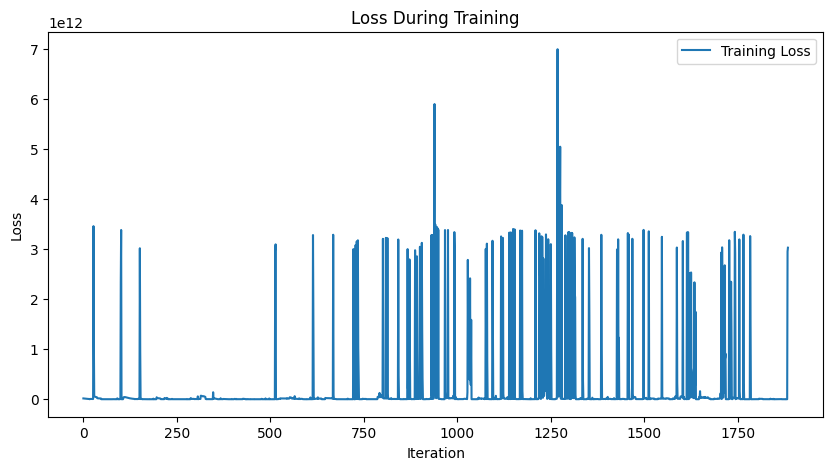

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(losses[100:], label='Training Loss')
plt.title('Loss During Training')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()


tensor([[ 898339.0625,  792633.6250, 1002988.0625,  130374.7422, 1790317.6250,
          787375.7500,  839658.5000,  438167.5625,  189607.5312,  470309.3750,
          670411.6875,  830914.7500,  472200.1875,  609863.5625,  365822.0938,
          310914.0625, 1005213.6875, -173032.2969, 1576202.5000, 1006308.6875]])
Action 0: Q Value = 898339.0625
Action 1: Q Value = 792633.625
Action 2: Q Value = 1002988.0625
Action 3: Q Value = 130374.7421875
Action 4: Q Value = 1790317.625
Action 5: Q Value = 787375.75
Action 6: Q Value = 839658.5
Action 7: Q Value = 438167.5625
Action 8: Q Value = 189607.53125
Action 9: Q Value = 470309.375
Action 10: Q Value = 670411.6875
Action 11: Q Value = 830914.75
Action 12: Q Value = 472200.1875
Action 13: Q Value = 609863.5625
Action 14: Q Value = 365822.09375
Action 15: Q Value = 310914.0625
Action 16: Q Value = 1005213.6875
Action 17: Q Value = -173032.296875
Action 18: Q Value = 1576202.5
Action 19: Q Value = 1006308.6875


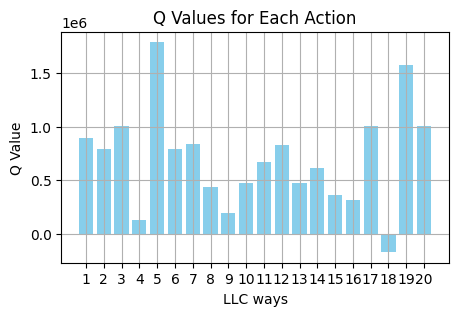

In [69]:
state_tensor = torch.FloatTensor(state).unsqueeze(0)  
policy_net.eval()  
with torch.no_grad():  
    q_values = policy_net(state_tensor)
    print(q_values)

with torch.no_grad():
    q_values = policy_net(state_tensor).squeeze()
    for action, q_value in enumerate(q_values.tolist()):
        print(f"Action {action}: Q Value = {q_value}")
#q_values[1]=27228528
#q_values[3]=28228528

actions = range(20) 
plt.figure(figsize=(5,3))
plt.bar([i+1 for i in actions], q_values, color='skyblue')
plt.title('Q Values for Each Action')
plt.xlabel('LLC ways')
plt.ylabel('Q Value')
plt.xticks([i+1 for i in actions])  
#plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.grid()
plt.show()


In [155]:
#generate samples
samples=[]
scaler = StandardScaler()
for i in range(len(df) - 1):  
    state = df.loc[i, state_columns].values.tolist()
   # state = state_space_scaled[i]
    action = df.loc[i, action_column].values.tolist()
    next_state = df.loc[i + 1, state_columns].values.tolist()
   # next_state = state_space_scaled[i + 1]
    next_action = df.loc[i + 1, action_column].values.tolist()
    reward = df.loc[i, 'throughput'] * df.loc[i, 'throughput']-df.loc[i, 'latency']

    samples.append((state, action, next_state, next_action, reward))
samples_df_1 = pd.DataFrame(samples, columns=['State', 'Action', 'Next State', 'Next Action', 'Reward'])
print(samples_df_1.iloc[1]['State'])

[5.65, 5.43, 1313955.1, 3.9, 27.43, 0.43, 8411102.0, 1110634.0]


# Using batch processing

In [79]:
import pandas as pd

# Path to your CSV file
csv_file = f'..\\DRL_framework\\ndpi-stats-random\\ndpi-stats-random_2000s.csv'
df = pd.read_csv(csv_file)
# Read the CSV file
#df = pd.read_csv(csv_file, header=[0, 1])

In [80]:
print(df.columns)

Index(['Unnamed: 0', 'input_rate', 'output_rate',
       'ndpi_stats-pcm_new_System-Date', 'ndpi_stats-pcm_new_System-Time',
       'ndpi_stats-pcm_new_Socket 0-EXEC', 'ndpi_stats-pcm_new_Socket 0-IPC',
       'ndpi_stats-pcm_new_Socket 0-FREQ', 'ndpi_stats-pcm_new_Socket 0-AFREQ',
       'ndpi_stats-pcm_new_Socket 0-L3MISS',
       ...
       'ddio_ways_new_cos_way', 'ddio_ways_new_binary',
       'ddio_ways_new_ddio_ways', 'latency_new_latency', 'tx_stats_PacketRate',
       'tx_stats_Mbit', 'tx_stats_MbitWithFraming', 'tx_stats_TotalPackets',
       'tx_stats_TotalBytes', 'packetsize'],
      dtype='object', length=173)


In [81]:
import pandas as pd
#state_columns_1 = ["input-rate", "throughput", "latency"]
state_columns = ["input_rate", "output_rate", "latency_new_latency","ndpi_stats-pcm_new_Socket 0-PhysIPC", "ndpi_stats-pcm_new_Socket 0-L3MISS", "ndpi_stats-pcm_new_Socket 0-L3HIT",
                   "pcm-pcie_new_skt-0_PCIRdCur-total", "pcm-pcie_new_skt-0_ItoM-total","packetsize"]
#state_columns = ["ndpi_stats-pcm_new_Socket 0-PhysIPC", "ndpi_stats-pcm_new_Socket 0-L3MISS", "ndpi_stats-pcm_new_Socket 0-L3HIT",
           #        "pcm-pcie_new_skt-0_PCIRdCur", "pcm-pcie_new_skt-0_ItoM"]
action_column = ["ddio_ways_new_ddio_ways"]
#stateskt-0_PCIRdCur-total
df = pd.read_csv(csv_file, usecols=state_columns+action_column)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   input_rate                           1986 non-null   float64
 1   output_rate                          1986 non-null   float64
 2   ndpi_stats-pcm_new_Socket 0-L3MISS   1986 non-null   float64
 3   ndpi_stats-pcm_new_Socket 0-L3HIT    1986 non-null   float64
 4   ndpi_stats-pcm_new_Socket 0-PhysIPC  1986 non-null   float64
 5   pcm-pcie_new_skt-0_PCIRdCur-total    1986 non-null   float64
 6   pcm-pcie_new_skt-0_ItoM-total        1986 non-null   float64
 7   ddio_ways_new_ddio_ways              1986 non-null   float64
 8   latency_new_latency                  1986 non-null   float64
 9   packetsize                           1986 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 155.3 KB


In [82]:
#scaler = StandardScaler()
scaler = MinMaxScaler()
state_space = df[state_columns].values 
scaler.fit(state_space)
state_space_scaled = scaler.transform(state_space)

In [83]:
#generate samples
samples=[]
scaler =MinMaxScaler()
for i in range(len(df) - 1):  
    state = state_space_scaled[i]
    action = df.loc[i, action_column].values.tolist()
    next_state = state_space_scaled[i + 1]
    next_action = df.loc[i + 1, action_column].values.tolist()
   # reward = df.loc[i, 'output_rate']/-df.loc[i, 'latency_new_latency']/10000-df.loc[i, 'ddio_ways_new_ddio_ways']
    reward = df.loc[i, 'output_rate']/1000-df.loc[i, 'latency_new_latency']/10000-df.loc[i, 'ddio_ways_new_ddio_ways']

    samples.append((state, action, next_state, next_action, reward))
samples_df = pd.DataFrame(samples, columns=['State', 'Action', 'Next State', 'Next Action', 'Reward'])

In [76]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        # Extracting row by row index (assuming dataframe is already correctly indexed)
        row = self.dataframe.iloc[index]
        state = torch.FloatTensor(row['State'])
        next_state = torch.FloatTensor(row['Next State'])
        action = torch.LongTensor([int(row['Action'][0])-1])
        # Converting 'Reward' to tensor
        reward = torch.FloatTensor([row['Reward']])
        return state, action, next_state, reward


In [77]:
batch_size = 16
num_epochs = 10
dataset = CustomDataset(samples_df)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
data_loader

In [84]:
#generate samples
samples=[]
scaler = StandardScaler()
for i in range(len(df) - 1):  
    state = df.loc[i, state_columns].values.tolist()
   # state = state_space_scaled[i]
    action = df.loc[i, action_column].values.tolist()
    next_state = df.loc[i + 1, state_columns].values.tolist()
   # next_state = state_space_scaled[i + 1]
   # next_action = df.loc[i + 1, action_column].values.tolist()
    reward = df.loc[i, 'output_rate']/1000  -df.loc[i, 'latency_new_latency']/100000-df.loc[i, 'ddio_ways_new_ddio_ways']/20

    samples.append((state, action, next_state, next_action, reward))
samples_df = pd.DataFrame(samples, columns=['State', 'Action', 'Next State', 'Next Action', 'Reward'])

In [85]:
losses.append(loss.item())
for epoch in range(num_epochs): 
    for states, actions, next_states, rewards in data_loader:

        # a batch 
        current_q_values = policy_net(states).gather(1, actions)
        next_q_values = target_net(next_states).detach().max(1)[0]
        expected_q_values = (next_q_values.unsqueeze(1) * 0.9) + rewards

        # ensure current_q_value and expected_q_values is the same
        loss = loss_fn(current_q_values, expected_q_values)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x9 and 4x24)

In [87]:
print(losses)

[90665568436224.0, 34405250760704.0, 1035410784387072.0, 5975273929441280.0, 9044251937603584.0, 9148205178552320.0, 9036169882894336.0, 8962137531613184.0, 9056197315395584.0, 9168433400774656.0, 8963408841932800.0, 9090534505185280.0, 9176775301005312.0, 8659670902243328.0, 9089098912366592.0, 9017772390481920.0, 9228106602643456.0, 9534573994049536.0, 9818265173884928.0, 9806739629146112.0, 9812606554472448.0, 9798880912736256.0, 9806801906171904.0, 9813283011821568.0, 7851947541397504.0, 9803884549636096.0, 9777970864455680.0, 9614298250739712.0, 9612058425294848.0, 9622854899335168.0, 9538949491982336.0, 9761310686314496.0, 9470567170179072.0, 9761565163126784.0, 6443620785717248.0, 9783422251696128.0, 9814540363497472.0, 9808151599644672.0, 9827694774583296.0, 9830224510320640.0, 9794649296207872.0, 9822472094351360.0, 9811913990995968.0, 9816465582587904.0, 9834517330132992.0, 7110384393650176.0, 9746930062065664.0, 9836337322524672.0, 9823239819755520.0, 9803837304995840.0, 983

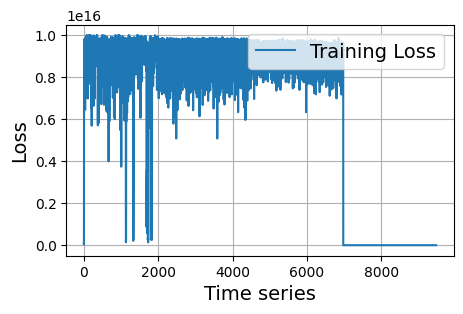

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3))
plt.plot(losses, label='Training Loss')
#plt.title('Training Loss Over Time')
plt.xlabel('Time series',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.legend(fontsize=14,loc='upper right')
plt.grid()
plt.show()


Action 0: Q Value = 282238.78125
Action 1: Q Value = 621825.375
Action 2: Q Value = 607744.625
Action 3: Q Value = 370834.59375
Action 4: Q Value = 583991.9375
Action 5: Q Value = 629347.3125
Action 6: Q Value = 501249.0625
Action 7: Q Value = 676795.375
Action 8: Q Value = 671286.5625
Action 9: Q Value = 439065.15625
Action 10: Q Value = 637226.6875
Action 11: Q Value = 591762.375
Action 12: Q Value = 665961.6875
Action 13: Q Value = 434975.03125
Action 14: Q Value = 644352.1875
Action 15: Q Value = 708009.0
Action 16: Q Value = 672308.625
Action 17: Q Value = 600705.4375
Action 18: Q Value = 512522.875
Action 19: Q Value = 382888.8125


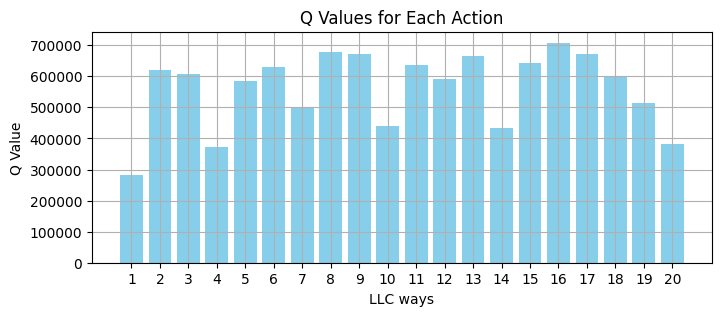

In [77]:
state_tensor = torch.FloatTensor(samples_df.iloc[80]['State']).unsqueeze(0)  
policy_net.eval()  
with torch.no_grad():  
    q_values = policy_net(state_tensor)

with torch.no_grad():
    q_values = policy_net(state_tensor).squeeze()
    for action, q_value in enumerate(q_values.tolist()):
        print(f"Action {action}: Q Value = {q_value}")


actions = range(20) 
plt.figure(figsize=(8,3))
plt.bar([i+1 for i in actions], q_values, color='skyblue')
plt.title('Q Values for Each Action')
plt.xlabel('LLC ways')
plt.ylabel('Q Value')
plt.xticks([i+1 for i in actions])  
#plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.grid()
plt.show()


In [40]:
for index, row in samples_df.iterrows():

    # Extract and convert the state, action, next state, and reward from the row
    state = torch.FloatTensor(row['State'])
    next_state = torch.FloatTensor(row['Next State'])


# offline test

In [81]:
#generate samples
samples=[]
scaler = StandardScaler()
for i in range(len(df) - 1):  
   # state = df.loc[i, state_columns].values.tolist()
    state = state_space_scaled[i]
    action = df.loc[i, action_column].values.tolist()
    next_state = state_space_scaled[i + 1]
    next_action = df.loc[i + 1, action_column].values.tolist()
    reward = df.loc[i, 'throughput']*df.loc[i, 'throughput']  -df.loc[i, 'latency']/1000000

    samples.append((state, action, next_state, next_action, reward))
samples_df = pd.DataFrame(samples, columns=['State', 'Action', 'Next State', 'Next Action', 'Reward'])

In [96]:
total_reward = 0
correct_actions = 0
num_samples = len(samples_df)
predicted_actions_list = [] 
for index, row in samples_df.iterrows():

    # Extract and convert the state, action, next state, and reward from the row
    state = torch.FloatTensor(row['State'])
   # print(state)
    next_state = torch.FloatTensor(row['Next State'])
    action = torch.LongTensor([int(row['Action'][0])-1])
    reward = torch.FloatTensor([row['Reward']])
   # print(reward)
    with torch.no_grad():
        action_values = policy_net(state)
       # print(action_values)
    predicted_action = action_values.argmax().item()
    predicted_actions_list.append(predicted_action) 
    
    if predicted_action == action:
        correct_actions += 1

    # total reward
    total_reward += reward
average_reward = total_reward / num_samples
accuracy = correct_actions / num_samples

if torch.is_tensor(average_reward):
    average_reward = average_reward.item()
if torch.is_tensor(accuracy):
    accuracy = accuracy.item()

print(f"Average Reward: {average_reward:.2f}")


Average Reward: 22.32


# compare with FSM (finite state machine)

In [111]:
from enum import Enum, auto

class State(Enum):
    LOW_KEEP = auto()
    HIGH_KEEP = auto()
    IO_DEMAND = auto()
    CORE_DEMAND = auto()
    RECLAIM = auto()

# Constants for thresholds and LLC ways
DDIO_WAYS_MIN = 1
DDIO_WAYS_MAX = 10  
THRESHOLD_MISS_LOW = 100000  

In [114]:
class IAT_FSM:
    def __init__(self):
        self.state = State.LOW_KEEP
        self.llc_ways_ddio = DDIO_WAYS_MIN  # Starting with minimum allocation
        self.previous_ddio_hit = None
        self.previous_llc_reference = None
    
    def transition(self, ddio_miss, ddio_hit, llc_reference):
        # Example for transitioning from LOW_KEEP state
        if self.state == State.LOW_KEEP:
            if ddio_miss > THRESHOLD_MISS_LOW:
                ddio_hit_decreases = self.previous_ddio_hit is not None and ddio_hit < self.previous_ddio_hit
                llc_reference_increases = self.previous_llc_reference is not None and llc_reference > self.previous_llc_reference
                
                if ddio_hit_decreases and llc_reference_increases:
                    self.state = State.CORE_DEMAND
                else:
                    self.state = State.IO_DEMAND
        
        # Remember to update the previous values at the end of the transition check
        self.previous_ddio_hit = ddio_hit
        self.previous_llc_reference = llc_reference
        
        # Add similar checks for other state transitions
        
    def allocate_llc_ways(self):
        # Based on the current state, allocate LLC ways
        if self.state == State.LOW_KEEP:
            self.llc_ways_ddio = DDIO_WAYS_MIN
        elif self.state == State.HIGH_KEEP:
            self.llc_ways_ddio = DDIO_WAYS_MAX
        # Define allocation logic for other states


In [115]:
# Example usage
iat_fsm = IAT_FSM()

# Simulate receiving data from Poll Prof Data
ddio_miss_count = 120  # Example data
ddio_hit_count = 80    # Example data
llc_reference_count = 150  # Example data

iat_fsm.transition(ddio_miss_count, ddio_hit_count, llc_reference_count)
iat_fsm.allocate_llc_ways()

print(f"Current State: {iat_fsm.state}, LLC Ways for DDIO: {iat_fsm.llc_ways_ddio}")


Current State: State.LOW_KEEP, LLC Ways for DDIO: 1


In [116]:
previous_throughput = throughput_data[0]  # Initialize with the first value

for i in range(len(throughput_data)):
    current_throughput = throughput_data[i]
    current_l3miss = l3miss_data[i]
    
    # Apply FSM logic
    new_llc_ways, action_taken = fsm_logic(current_throughput, previous_throughput, current_l3miss, current_llc_ways)
    
    print(f"Step {i}: Throughput={current_throughput}, L3MISS={current_l3miss}, LLC Ways={new_llc_ways} ({action_taken})")
    
    # Update for next iteration
    current_llc_ways = new_llc_ways
    previous_throughput = current_throughput


Step 0: Throughput=1000, L3MISS=9000, LLC Ways=5 (No Change)
Step 1: Throughput=950, L3MISS=12000, LLC Ways=5 (No Change)
Step 2: Throughput=900, L3MISS=8000, LLC Ways=5 (No Change)
Step 3: Throughput=850, L3MISS=13000, LLC Ways=5 (No Change)
Step 4: Throughput=500, L3MISS=70000, LLC Ways=6 (Increased)
